# **Introduction**

International Essentials is an international supermarket chain.

Shoppers at their supermarkets can sign up for a loyalty program that provides rewards each year to customers based on their spending. The more you spend the bigger the rewards. 

The supermarket would like to be able to predict the likely amount customers in the program will spend, so they can estimate the cost of the rewards. 

This will help them to predict the likely profit at the end of the year.

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import calendar
from scipy.stats import mannwhitneyu, kruskal
from statsmodels.stats.proportion import proportions_ztest


In [159]:
customer_data = pd.read_csv("loyalty.csv")
print(customer_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           1246 non-null   int64  
 1   spend                 1246 non-null   float64
 2   first_month           1246 non-null   object 
 3   items_in_first_month  1246 non-null   int64  
 4   region                1246 non-null   object 
 5   loyalty_years         1246 non-null   object 
 6   joining_month         1121 non-null   object 
 7   promotion             1246 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 78.0+ KB
None


# **Checking the data columns by column**  
First I am checking the data accordingly to what we should expect.  
We can already see in the table above that there are missing data in 'joining_month'.  
 
## **customer_id**  
All the values should be unique.  


In [160]:
print(len(customer_data["customer_id"].unique()))
len(customer_data)

1246


1246

## **spend**  
Continuous. </br>The total spend of the customer in their last full year. This can be any positive value to two decimal places. </br>Missing values should be replaced with 0. 

In [161]:
print(customer_data["spend"].describe())

count    1246.000000
mean      122.637119
std         9.975102
min       104.290000
25%       112.210000
50%       123.840000
75%       131.092500
max       142.290000
Name: spend, dtype: float64


There are no missing values and no 0 (the minimum is 104.29).  
Furthermore, it seems that the values are all rounded to 2 decimals (see the median).  
However, just to be sure I will round to 2 decimals the column.  

In [162]:
customer_data["spend"] = customer_data["spend"].round(2)

## **first_month**  
Continuous. </br>The amount spent by the customer in their first month of the year. This can be any positive value, rounded to two decimal places. </br>Missing values should be replaced with 0.  

Based on the general info, this column is an object type (string). It should be a float.  

In [163]:
print(customer_data["first_month"].value_counts(dropna=False))
print(customer_data["first_month"].isna().sum())

first_month
.        125
21.38     12
21.33     10
21.35      9
21.39      9
        ... 
15.71      1
25.28      1
24.41      1
19.95      1
26.18      1
Name: count, Length: 491, dtype: int64
0


There are no missing values, but the reason of the type 'object' is the ".". I will replace it to 0 and change to float type.

In [164]:
customer_data["first_month"].replace(".",None, inplace=True)
customer_data["first_month"] = customer_data["first_month"].astype(float)
customer_data["first_month"].fillna(0, inplace=True)
print(customer_data["first_month"].describe())

count    1246.000000
mean       17.161998
std         6.583749
min         0.000000
25%        15.750000
50%        19.125000
75%        21.280000
max        26.200000
Name: first_month, dtype: float64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\2959011451.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["first_month"].replace(".",None, inplace=True)
C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\2959011451.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [165]:
customer_data["first_month"] = customer_data["first_month"].round(2)
print(customer_data["first_month"].describe())

count    1246.000000
mean       17.161998
std         6.583749
min         0.000000
25%        15.750000
50%        19.125000
75%        21.280000
max        26.200000
Name: first_month, dtype: float64


## **items_in_first_month**
Discrete. </br>The number of items purchased in the first month. Any integer value greater than or equal to zero. </br>Missing values should be replaced by 0.  

Based on the general info, the type is integer so it's a good type. Furthermore there are no missing values. So let's see if we have 0. If we do not have 0, I will have to compare with the customers who have spent nothing in the first month.  

In [166]:
print(customer_data["items_in_first_month"].describe())

count    1246.000000
mean        9.418138
std         3.000288
min         5.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        15.000000
Name: items_in_first_month, dtype: float64


Humm...We do not have any 0 as minimum. I will go back to it in the next chapter. For now I am only doing a general scrolling.  

## **region**
Nominal. </br>The geographic region that the customer is based in. One of four values Americas, Asia/Pacific, Europe, Middle East/Africa. </br>Missing values should be replaced with "Unknown".  
In the general info this column is an object. So far so good.  

In [167]:
print(customer_data["region"].value_counts(dropna=False))

region
Middle East/Africa    326
Europe                320
Americas              309
Asia/Pacific          291
Name: count, dtype: int64


Everything seems in Ordnung. So I will switch to categorical to gain some space.  

In [168]:
customer_data["region"] = customer_data["region"].astype("category")

## **loyalty_years**  
Ordinal. </br>The number of years the customer has been a part of the loyalty program. One of five ordered categories, '0-1', '1-3', '3-5', '5-10', '10+'. </br>Missing values should be replaced with '0-1'.  
Right now the column is an object and needs to be changed into an ordered categorical type.  

In [169]:
print(customer_data["loyalty_years"].value_counts(dropna=False, sort=False))

loyalty_years
5-10    250
0-1     382
10+     117
3-5     256
1-3     241
Name: count, dtype: int64


I have to switch to categories. Right now they are not ordered at all.  

In [170]:
customer_data["loyalty_years"] = customer_data["loyalty_years"].astype("category")
new_categories = ["0-1","1-3","3-5","5-10","10+"]
customer_data["loyalty_years"] = customer_data["loyalty_years"].cat.reorder_categories(new_categories=new_categories, ordered=True)
print(customer_data["loyalty_years"].value_counts(sort=False))

loyalty_years
0-1     382
1-3     241
3-5     256
5-10    250
10+     117
Name: count, dtype: int64


## **joining_month**  
Nominal. </br>The month the customer joined the loyalty program. One of 12 values "Jan", "Feb", "Mar", "Apr", etc. </br>Missing values should be replaced with "Unknown". We saw in the table info that we have 1121 non-null data so there are 125 missing values.

In [171]:
#joining_month_num will be used for modelisation
#customer_data["joining_month_num"] = pd.to_datetime(customer_data["joining_month"], format="%b")
#customer_data["joining_month_num"] = customer_data["joining_month_num"].dt.month
#customer_data["joining_month_num"].fillna(0, inplace=True)

customer_data["joining_month"].fillna("Unknown", inplace=True)
ordered_month = ['Unknown', "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
customer_data["joining_month"] = customer_data["joining_month"].astype("category")
customer_data["joining_month"] = customer_data["joining_month"].cat.reorder_categories(new_categories=ordered_month\
                                                                                       , ordered=True)

print(customer_data["joining_month"].value_counts(sort=False, dropna=False))
#print(customer_data["joining_month_num"].value_counts(dropna=False))


joining_month
Unknown    125
Jan        146
Feb        109
Mar         85
Apr         93
May         96
Jun         75
Jul        111
Aug         91
Sep         88
Oct        107
Nov         75
Dec         45
Name: count, dtype: int64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\1692947462.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data["joining_month"].fillna("Unknown", inplace=True)


## **promotion**
Nominal. </br>Did the customer join the loyalty program as part of a promotion? Either 'Yes' or 'No'. </br>Missing values should be replaced with 'No'.

In [172]:
print(customer_data["promotion"].value_counts(dropna=False))

promotion
No     572
Yes    549
NO      63
YES     62
Name: count, dtype: int64


We have some typo problems. Let's clean this up.

In [173]:
customer_data["promotion"] = customer_data["promotion"].str.title()
print(customer_data["promotion"].value_counts())

promotion
No     635
Yes    611
Name: count, dtype: int64


# **EDA (Exploratory Data Analysis)**  
Now I have cleaned up every column, I will do an EDA.  
Notably, I will focus on 'first_month' where there are a non-negligeable amount of customers who spent 0 in their first month while every customers got at least 5 items in their first-month. The other column we need to focus on is 'joining_month' where there are 125 "Unknown" month. Do we keep them as Uknown? Do we remove them or do we inpute them (with the mode or other)?    

## **The customers who haven't spent a dime in their first month**  

10% of our customers have spent nothing in their 1st month of the year although they did get stuffs since I do not have 0 items bought in the first month.  
The question we can therefore ask is: Is that a mistake or have they took full advantage of their yearly reward?  
Therefore, to compare this category of customers with the others, I am creating a column called 'rewarded_vs_not' that contains 2 categories:  
- "rewarded" : the group of customers who took full advantage of their reward and didn't spend a dime on their first month;  
- "invested" : the group of customers who still paid something on their first month.  

In [174]:
customer_data["rewarded_vs_not"] = np.where(customer_data["first_month"] == 0, "rewarded", "invested")
print(customer_data.groupby("rewarded_vs_not")["spend"].describe())

                  count        mean        std     min     25%     50%  \
rewarded_vs_not                                                          
invested         1121.0  122.575513  10.034816  104.29  112.19  123.84   
rewarded          125.0  123.189600   9.443026  104.50  112.50  124.73   

                    75%     max  
rewarded_vs_not                  
invested         130.99  142.29  
rewarded         131.18  141.85  


Contrary to what I was expecting, I do not see any obvious difference in the year spending between the two groups, suggesting that their reward is not higher than the others (remember that more they spend, higher is the reward).  
I can make a quick statistical test to see if that's the case (H0 = no difference of year spend; alpha = 0.05).  

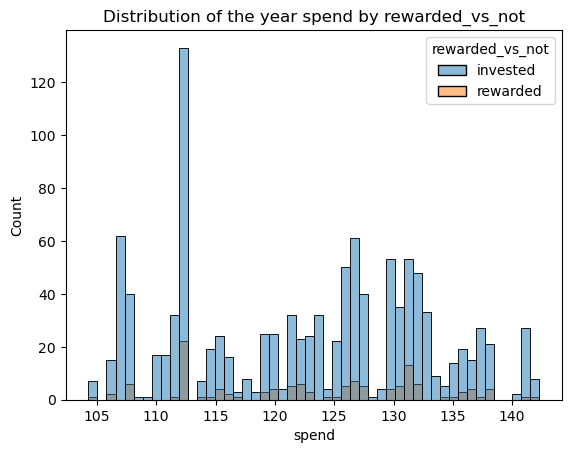

In [175]:
#look at the distribution of spend
sns.histplot(x="spend", data=customer_data, hue="rewarded_vs_not", bins=50)
plt.title("Distribution of the year spend by rewarded_vs_not")
plt.show()

The spending is not normally distributed (it looks almost like a uniform distribution), so I will use a non parametric statiscal test. Because I am comparing only 2 samples, I will use a Mann-Whitney U test.

In [176]:
alpha = 0.05
spend_U_stat, spend_U_pval = mannwhitneyu(customer_data[customer_data["rewarded_vs_not"] == "rewarded"]["spend"],\
                                          customer_data[customer_data["rewarded_vs_not"] == "invested"]["spend"])
print(f"Mann-Whitney U test p_val: {spend_U_pval:0.4f}")

Mann-Whitney U test p_val: 0.4679


There is no significant difference of the amount spend over the year between the people who took fully advantage of their rewards and the ones who haven't.  
Perhaps the ones who did spend some money on their renewal month bought more items which would have included the free ones plus others.  

### **Do the customers who spent some money on their first month, buy more items in that month?**  
The idea here is that if these customers who do not spend more than the others over a year use all their reward on their first month, they may get less items than the ones who have spent some money on their first month.  

In [177]:
print(customer_data.groupby("rewarded_vs_not")["items_in_first_month"].describe())

                  count      mean       std  min  25%  50%   75%   max
rewarded_vs_not                                                       
invested         1121.0  9.443354  3.025878  5.0  7.0  9.0  13.0  15.0
rewarded          125.0  9.192000  2.761183  5.0  7.0  9.0  11.0  14.0


Once again, I do not see any significant differences between the two groups (the median is exactly the same).

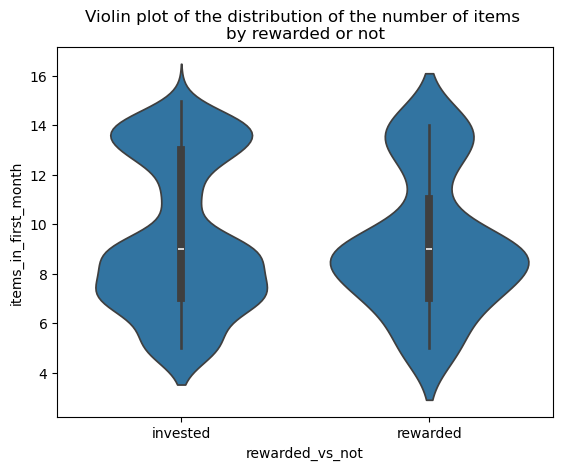

In [178]:
sns.violinplot(x="rewarded_vs_not", y="items_in_first_month", data=customer_data)
plt.title("Violin plot of the distribution of the number of items \nby rewarded or not")
plt.show()

The violin plot shows however 2 groups of number of items in both "invested" and "rewarded" subpopulations. As shown in the table, the median (white line) is exactly the same.  
However, among the minorities who bought more than 10 items, the population seems slightly larger in the invested customers (the ones who did spend some money on their first month). Question would be therefore to test whether the proportion of n_items > 10 in the "invested" subpopulation is significantly higher than the one in the "rewarded" subpopulation. 
I will do a proportion test.  
H0 = the proportion of items > 10 is the same between rewarded and invested.  
H1 = the proportion of items > 10 in the rewarded population is lower than in the invested.  
alpha = 0.05

In [179]:
customer_data["big_items_nb"] = np.where(customer_data["items_in_first_month"] > 10, ">10", "<10")
p_hats = customer_data.groupby("rewarded_vs_not")["big_items_nb"].value_counts(normalize = True)
print(p_hats)
n_big_small_items = customer_data.groupby("rewarded_vs_not")["big_items_nb"].value_counts()
print(n_big_small_items)
n_more_10 = np.array([397, 34])
n_rows = np.array([724+397, 91+34])
z_score,p_value = proportions_ztest(count=n_more_10, nobs=n_rows, alternative="larger")
print(z_score, p_value)

rewarded_vs_not  big_items_nb
invested         <10             0.645852
                 >10             0.354148
rewarded         <10             0.728000
                 >10             0.272000
Name: proportion, dtype: float64
rewarded_vs_not  big_items_nb
invested         <10             724
                 >10             397
rewarded         <10              91
                 >10              34
Name: count, dtype: int64
1.8314574062017945 0.03351614982201288


with an alpha=0.05 I can reject H0 (p=0.0335) and conclude that the proportion of people buying more than 10 items in their first month is higher in the invested population compared to the rewarded (the ones who bought stuff only with their reward).  
However, the difference is very small (0.354 vs 0.272). Some improvements should be done to encourage the customers to use their rewards AND buy stuff with real money.  

## **The "Unknown" of the 'joining_month'.**
What shoud we do with the "unknown" category in the 'joining_month?  


In [180]:
customer_data["joining_month"].value_counts(normalize=True)

joining_month
Jan        0.117175
Unknown    0.100321
Jul        0.089085
Feb        0.087480
Oct        0.085875
May        0.077047
Apr        0.074639
Aug        0.073034
Sep        0.070626
Mar        0.068218
Jun        0.060193
Nov        0.060193
Dec        0.036116
Name: proportion, dtype: float64

This category is 2nd in the list and represents 10% of our sample. Hence, we cannot ignore it.

Text(0.5, 1.0, 'Average of year spend per joining month')

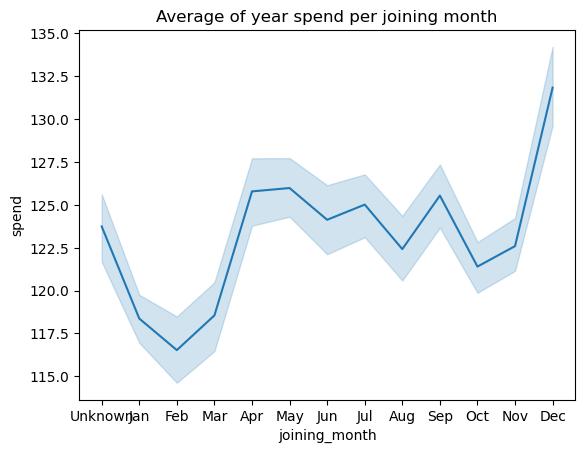

In [181]:
the_unknown = customer_data[customer_data["joining_month"] == "Unknown"]
sns.lineplot(x="joining_month", y="spend", data=customer_data)
plt.title("Average of year spend per joining month")

I cannot inpute this category with any other month based on the spend.  
Indeed, we can see 3 periods:  
- January to Mars. The customers who joined the membership in this period are the ones who spend the least in their year;  
- April to November. The customers who joined the membership in this spend roughly a similar amount in their year with the exception of April (perhaps du to Easter);  
- December seems the most fruitful joining month.  
The "unknown" group is in the same range of spend as April to November. I could potentially design a predictive model using joining month as target variable to predict the joining month in the "Unknown" group. However, I have a very good score (R²) in my predictive model (where spend is the target varaible) when I keep this category as it is. So I will not change it.  

## **Does loyalty pay off (to our advantage of course)?**
The team at International Essentials have told me that they have always believed that the number of years in the loyalty scheme is the biggest driver of spend.  
Let's see if they have a good instinct.  

In [182]:
print(customer_data.groupby("loyalty_years")["spend"].describe())

               count        mean       std     min       25%      50%  \
loyalty_years                                                           
0-1            382.0  110.557461  3.050032  104.29  107.5625  111.815   
1-3            241.0  129.308340  3.106174  123.66  126.5200  130.200   
3-5            256.0  124.550547  3.329429  119.16  121.6975  125.110   
5-10           250.0  135.150040  3.755654  129.75  132.2400  135.565   
10+            117.0  117.411453  4.089553  111.88  114.1000  117.680   

                    75%     max  
loyalty_years                    
0-1            112.1775  118.36  
1-3            131.5700  137.47  
3-5            127.0625  131.34  
5-10           137.7375  142.29  
10+            119.9900  124.26  


C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\3689172978.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer_data.groupby("loyalty_years")["spend"].describe())


Text(0.5, 1.0, 'Boxplot of spend by the length of loyalty')

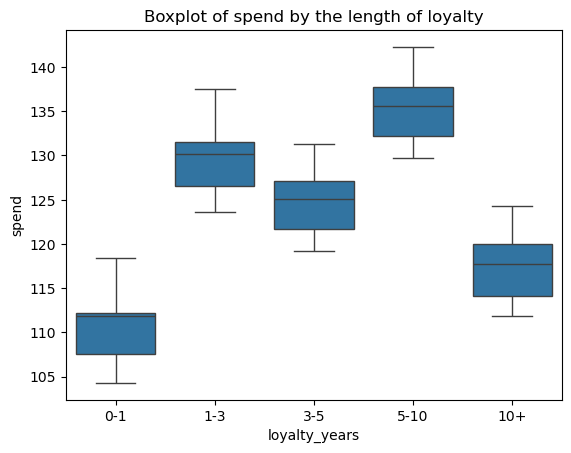

In [183]:
sns.boxplot(x="loyalty_years", y="spend", data=customer_data)
plt.title("Boxplot of spend by the length of loyalty")

The team was right and wrong.  
They were right in a sense that after a year of membership, the customers "see" the advantage of having this reward card and therefore increase dramatically their expenses with us in their year. Furthermore, we do see a significant increase (significant because 75% of the sample is above the other IQR of 1-3 and 3-5) at length 5-10 years. However, there is a "fatigue" from our customers past this time. Perhaps we should find a trategy to revitalise this population.

### **Task 2 (This is part of DataCamp excersise so I am doing it)**

The team at International Essentials have told you that they have always believed that the number of years in the loyalty scheme is the biggest driver of spend. 

Producing a table showing the difference in the average spend by number of years in the loyalty programme along with the variance to investigate this question for the team.

 - You should start with the data in the file 'loyalty.csv'.

 - Your output should be a data frame named `spend_by_years`. 

 - It should include the three columns `loyalty_years`, `avg_spend`, `var_spend`. 

 - Your answers should be rounded to 2 decimal places.  

In [184]:
spend_by_years = pd.DataFrame(customer_data.groupby("loyalty_years")["spend"].agg(avg_spend = "mean", var_spend = "var"))
spend_by_years = spend_by_years.reset_index()
spend_by_years["avg_spend"] = spend_by_years["avg_spend"].round(2)
spend_by_years["var_spend"] = spend_by_years["var_spend"].round(2)
print(spend_by_years)

  loyalty_years  avg_spend  var_spend
0           0-1     110.56       9.30
1           1-3     129.31       9.65
2           3-5     124.55      11.09
3          5-10     135.15      14.10
4           10+     117.41      16.72


C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\1453631747.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spend_by_years = pd.DataFrame(customer_data.groupby("loyalty_years")["spend"].agg(avg_spend = "mean", var_spend = "var"))


## **Does the amount spent depends on when you started your membership?**  
I have already looked at the spend by joining-month to look more closely at the "Unknown" category. However, here I am looking more at a trend (the customers behaviour) and therefore I am including the items_in_first_month and also compare "rewarded" vs "invested".  

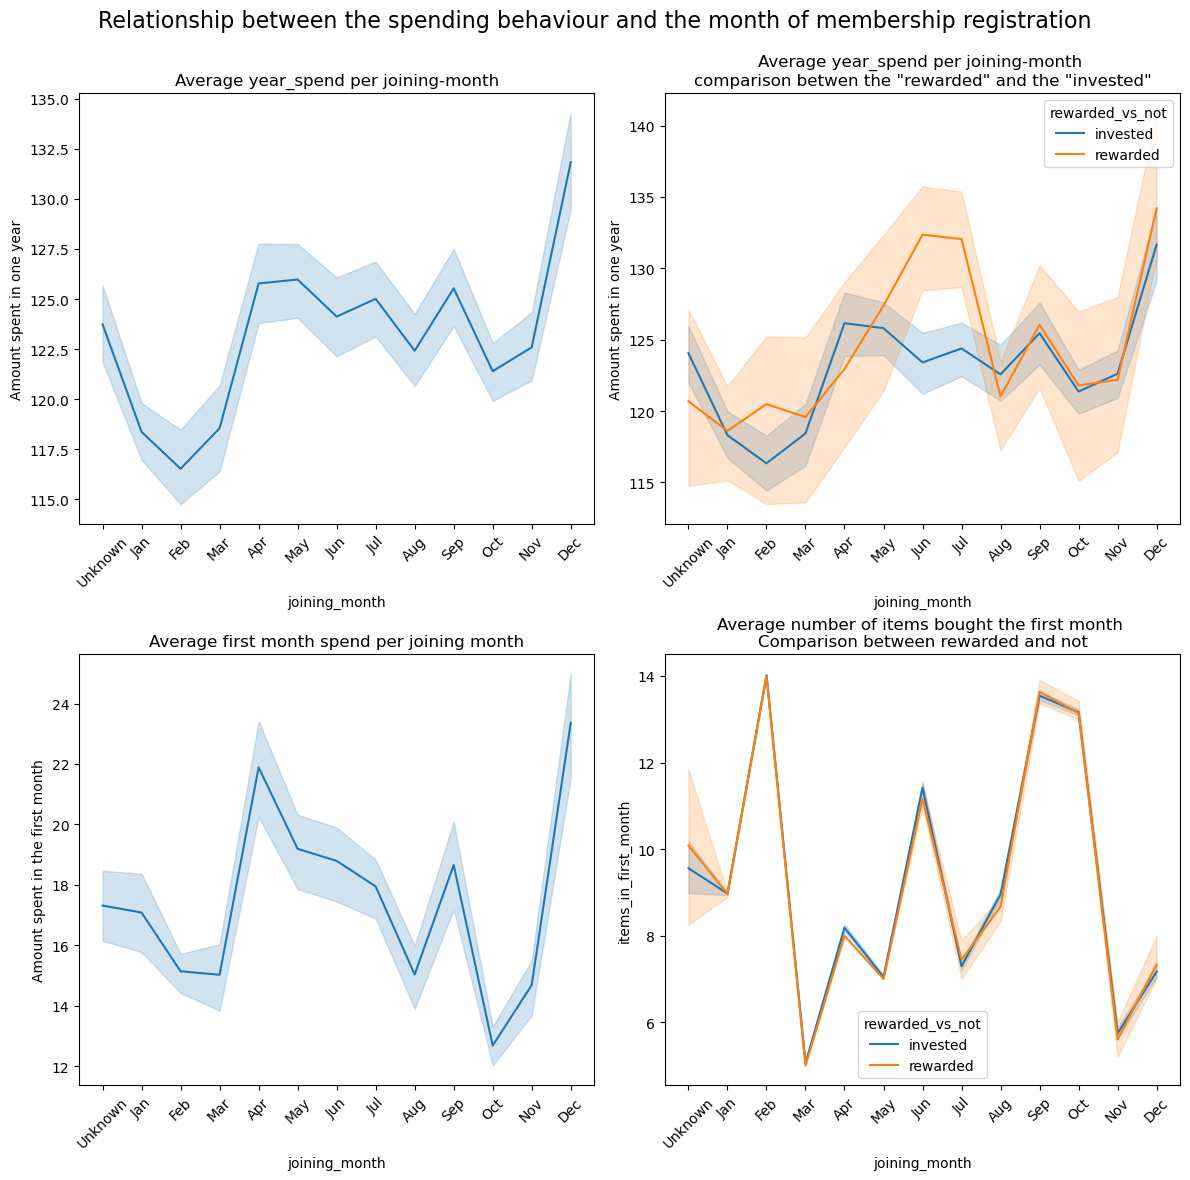

In [185]:
fig,axes = plt.subplots(2,2, figsize=(12,12))
sns.lineplot(x="joining_month", y="spend", data=customer_data, ax=axes[0,0])
sns.lineplot(x="joining_month", y="spend", data=customer_data, hue="rewarded_vs_not", ax=axes[0,1])
axes[0,0].set_title("Average year_spend per joining-month")
axes[0,1].set_title('Average year_spend per joining-month \ncomparison betwen the "rewarded" and the "invested"' )
axes[0,0].set_ylabel("Amount spent in one year")
axes[0,1].set_ylabel("Amount spent in one year")
axes[0,0].tick_params(axis="x", rotation=45)
axes[0,1].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="first_month", data=customer_data, ax=axes[1,0])
axes[1,0].set_title("Average first month spend per joining month")
axes[1,0].set_ylabel("Amount spent in the first month")
axes[1,0].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="items_in_first_month", data=customer_data, hue="rewarded_vs_not", ax=axes[1,1])
axes[1,1].set_title("Average number of items bought the first month \nComparison between rewarded and not")
axes[1,1].tick_params(axis="x", rotation=45)
plt.tight_layout()
fig.suptitle("Relationship between the spending behaviour and the month of membership registration", fontsize=16)
plt.subplots_adjust(top=0.91)
plt.show()


A lot of info here.  
Overall, the customers who are spending the most in their full membership year are the ones who joined "the club" in December (Comparison spend December with Spend Apr-Nov; p=1.27e-06). December is also the joining month where the customers buy the least number of items (with the exception of March but March is a "cheap" month). This suggests that they buy expensive stuff on average whether they use only their rewards or complement with money.  
This makes sense. In December we have two big festive events: christmas and New Year's eve.  
  February and March are clearly "doomed" months (for us) to join the loyalty membership. People who start their membership year in February-March are the ones who spend the least in their year and in their first month. Furthermore, for some reason (maybe we are doing some sale season then), customers who joined in February buy a lot of cheap products (with their rewards only or complementing with some spending but not much, about 15).  
Interestingly however, if we look more specifically at the customers who make the best of their reward card (meaning that they do not pay a dime at their anniversary membership), we can see that the ones who took their membership in summer (June-July) spend similarly in their year as the customers who joined in December (p=0.92). It would be interesting to check why is that.  

In [186]:
high_spend = customer_data[~(customer_data["joining_month"].isin(["Jan","Feb","Mar"]))]
high_spend["joining_month"] = high_spend["joining_month"].cat.remove_categories(removals=["Jan","Feb","Mar"])
not_december = high_spend[high_spend["joining_month"] != "Dec"]
not_december["joining_month"] = not_december["joining_month"].cat.remove_categories(["Dec"])
december = customer_data[customer_data["joining_month"] == "Dec"]
print(december["spend"].describe())
print(not_december["spend"].describe())

count     45.000000
mean     131.820667
std        8.403453
min      115.690000
25%      123.500000
50%      130.920000
75%      141.000000
max      141.820000
Name: spend, dtype: float64
count    861.000000
mean     124.056829
std        9.422304
min      104.290000
25%      115.520000
50%      125.720000
75%      131.600000
max      142.290000
Name: spend, dtype: float64


C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\1807335654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_spend["joining_month"] = high_spend["joining_month"].cat.remove_categories(removals=["Jan","Feb","Mar"])
C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\1807335654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_december["joining_month"] = not_december["joining_month"].cat.remove_categories(["Dec"])


In [187]:
#stat Mann-Whitney U
U_spendSeason_stat, U_spendSeas_pval = mannwhitneyu(december["spend"],not_december["spend"])
print(U_spendSeas_pval)

1.266614702556981e-06


In [188]:
june_july = high_spend[high_spend["joining_month"].isin(["Jun","Jul"])]
rewarded_june_july = june_july[june_july["rewarded_vs_not"] == "rewarded"]

#stats
U_rewSpend_stat, U_rewSpend_pval = mannwhitneyu(rewarded_june_july["spend"],december["spend"])
print(U_rewSpend_pval)

0.9251925526701301


## **Does the region have an effect on the spending?**

In [189]:
print(customer_data.groupby(["region","joining_month"])["spend"].describe())

                                  count        mean        std     min  \
region             joining_month                                         
Americas           Unknown         42.0  123.595000  10.878574  104.32   
                   Jan             40.0  117.998750   8.925397  111.73   
                   Feb             28.0  117.711429  11.102068  106.28   
                   Mar             25.0  115.380800   9.172389  107.55   
                   Apr             27.0  127.968519  10.145777  115.11   
                   May             29.0  125.821379   9.575094  112.07   
                   Jun             14.0  120.309286   9.257800  110.82   
                   Jul             27.0  123.997407   9.654384  109.71   
                   Aug             21.0  124.687143   7.322069  107.26   
                   Sep             16.0  124.011875  11.659120  112.12   
                   Oct             21.0  119.776667   8.266000  104.41   
                   Nov             16.

C:\Users\Angelique\AppData\Local\Temp\ipykernel_22716\590728671.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(customer_data.groupby(["region","joining_month"])["spend"].describe())


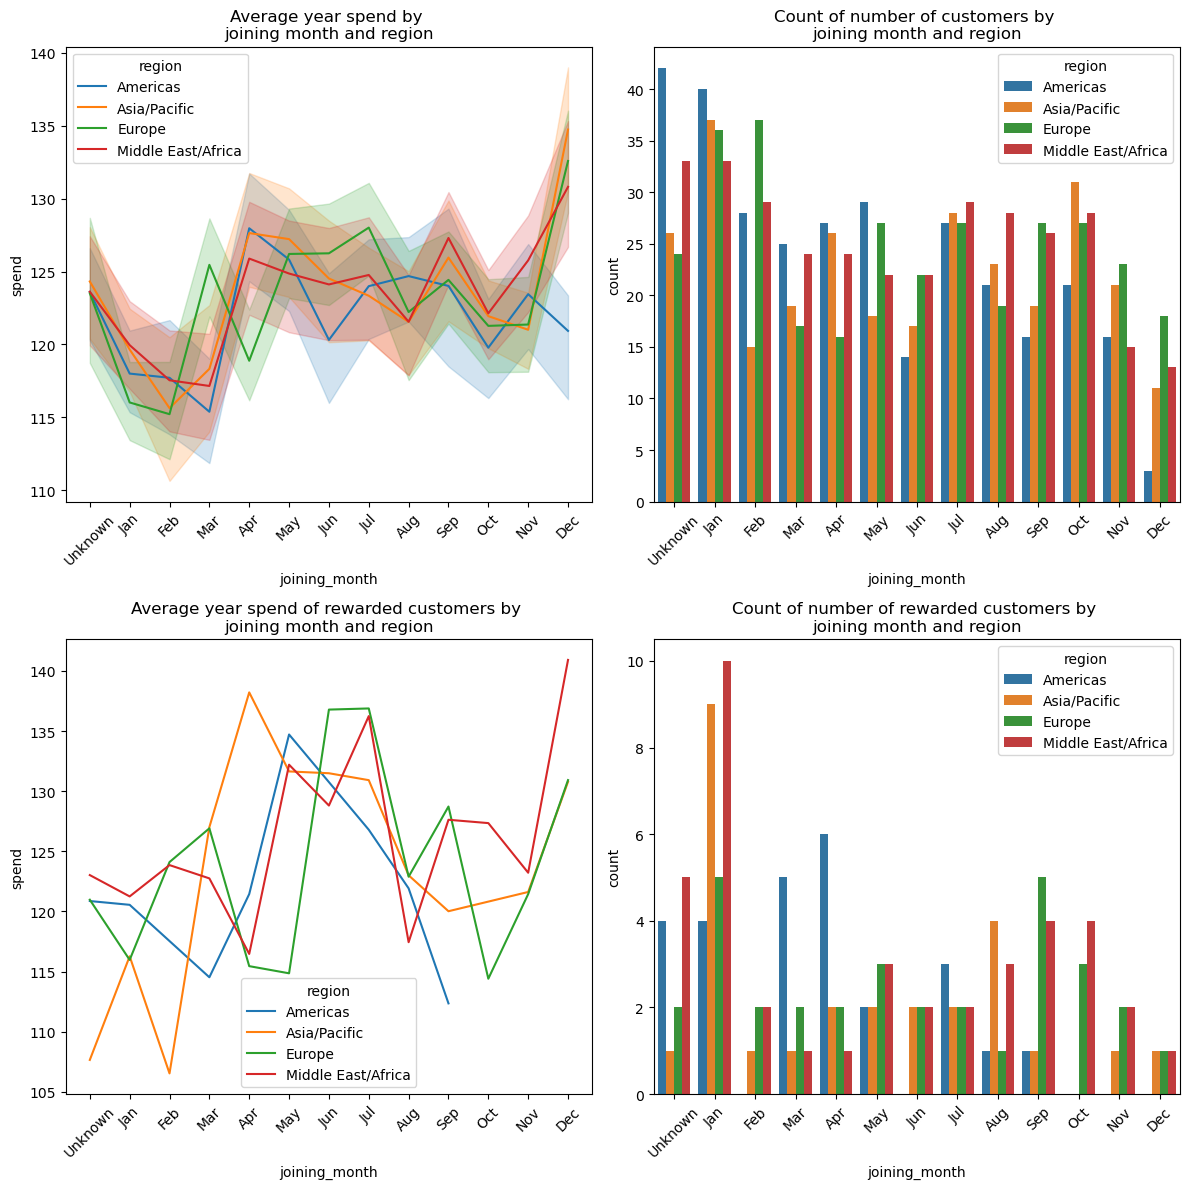

In [190]:
fig,axes = plt.subplots(2,2, figsize=(12,12))
sns.lineplot(x="joining_month", y="spend", data=customer_data, hue="region", ax=axes[0,0])
axes[0,0].set_title("Average year spend by \njoining month and region")
axes[0,0].tick_params(axis="x", rotation=45)
sns.countplot(x="joining_month", data=customer_data, hue="region", ax=axes[0,1])
axes[0,1].set_title("Count of number of customers by \njoining month and region")
axes[0,1].tick_params(axis="x", rotation=45)
sns.lineplot(x="joining_month", y="spend", data=customer_data[customer_data["rewarded_vs_not"] == "rewarded"]\
             ,hue="region", errorbar=None, ax=axes[1,0])
axes[1,0].set_title("Average year spend of rewarded customers by \njoining month and region")
axes[1,0].tick_params(axis="x", rotation=45)
sns.countplot(x="joining_month", data=customer_data[customer_data["rewarded_vs_not"] == "rewarded"]\
              ,hue="region", ax=axes[1,1])
axes[1,1].set_title("Count of number of rewarded customers by \njoining month and region")
axes[1,1].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

Naughty naughty americans...The largest group is unknown for when they joined the membership. Furthermore, only 3 american customers joined in December.  
Hence, apart from the americans who joined in December (too few to make any solid conclusion), our customers spend worldwild pretty much similarly.  
However, knowing that December is the most fruitful joining month, we should focus on making a campaign of membership in that month, especially in the american countries. America is a christian continent where Christmas and new year's are the most important gathering (family and friends) moments (along with Easter).  


In [191]:
print(customer_data["region"].value_counts())

region
Middle East/Africa    326
Europe                320
Americas              309
Asia/Pacific          291
Name: count, dtype: int64


The regional division is pretty much homegenous.

## **Is promotion a good indicator?**
A feature that I haven't looked at is 'promotion': whether the customer has joined the membership as part of a promotion.  


Text(0.5, 1.0, 'Average spend per joining month by promotion')

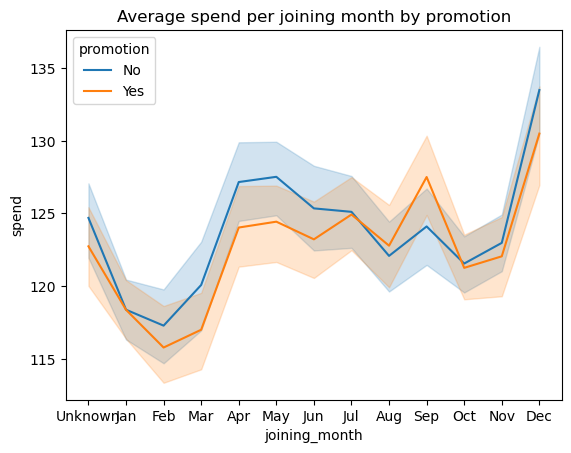

In [192]:
sns.lineplot(x="joining_month", y="spend", data=customer_data, hue="promotion")
plt.title("Average spend per joining month by promotion")

I don't think there are any significant different at all times. This is easy to check.  

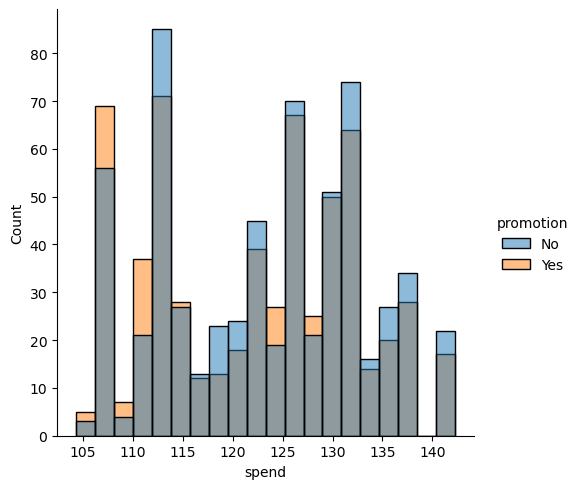

In [193]:
sns.displot(x="spend", data=customer_data, hue="promotion", bins=20)

In [194]:
alpha = 0.05
prom_U_stat,prom_U_pval = mannwhitneyu(customer_data[customer_data["promotion"] == "Yes"]["spend"]\
                                       ,customer_data[customer_data["promotion"] == "No"]["spend"])
print("Mann-Whitney U Test p_val: {}".format(round(prom_U_pval,4)))

Mann-Whitney U Test p_val: 0.0674


There is indeed no significant difference between promotion_yes and promotion_no in their spend. We can remove this feature for our predictive model (target variable: 'spend').

## **Conclusion and suggestions from my EDA**  
Our supermarket *International Essentials* has a loyalty card where customers get rewards at the end of the membership year depending on their expenses with us. The more you spend money bigger is the reward.  
Overall, I would suggest to encourage customers to join this loyalty program in December, as December is the joining month with the higher year spending And also spending in the renewal month (first_month). I will also focus on the Americas. Indeed, this continent is a christian continent and Christmas and New year's eve are very important. Importantly people are much willing to spend more in that period and a loyalty card will encourage them to buy mostly with us in this period. December is also the joining month where I have the least of the customers from Americas. Hence, there is a lot of space to improve there. April is also a good time to encourage joining (because of the presence of Easter).  
Another thing to improve is the length of loyalty. Yes, our team got a good instinc by saying more loyal more money you spend however, after a long period (10+) we can see a certain fatigue. We need to develop a campaign focusing on these very loyal customers. They need to feel special. Perhaps a 10 years super big reward anniversary.  
finally, we can remove this promotion thingy as it doesn't make any difference.


# **Supervised machine learning, predictive model for 'spend'**  
After looking at the relationships between 'spend' (our target variable) and the available features, I will now answer the main question of this little project: predict the likely amount customers in the program will spend in their year.  
For this, I will first preprocess the data and then try 3 linear regression models and from there decide on which one to take.  
I will try the model on a new set of data and check whether I can confidently offer this predictive model.  

## **Feature engineering**  
I am removing the unecessary features and create one-hot encodings for my categorical data.

### **Removing unecessary features**  
I am removing customer_id (only unique values) and promotion (no difference in spend between yes and no).  

In [195]:
customer_data = customer_data.drop(["customer_id", "promotion"], axis=1)


### **One-hot encoding**

In [196]:
customers_dummies = pd.get_dummies(customer_data, drop_first=True)

## **Choosing the model**  

My target variable is 'spend', the question being whether we can predict how much a customer will spend during its year based on these features we have.  
We need to use linear regression (our target variable is continuous). I will evaluate the 3 linear regression models I know:  
- The classic LinearRegression;  
- Ridge;  
- Lasso;  
For Ridge and Lasso I will use the same hyperparameter alpha=0.1.  
I will standardize the data (even though they are not normalised) using StandardScaler. If I don't have great result I will look for another one.  

In [197]:
#Packages for modelisation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [198]:
#X and y for no_region
X_dummies = customers_dummies.drop("spend", axis=1).values
y_dummies = customers_dummies["spend"].values


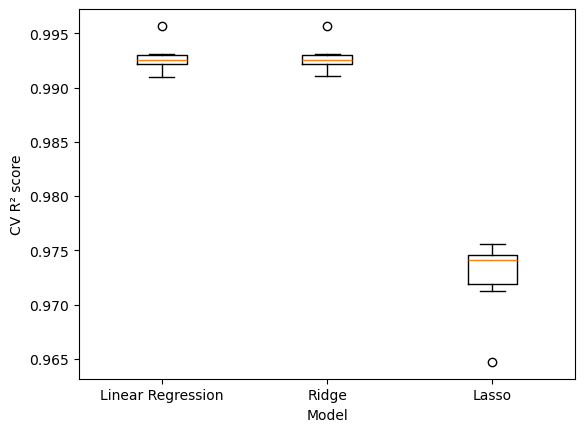

In [199]:
X_dum_train, X_dum_test, y_dum_train, y_dum_test = train_test_split(X_dummies, y_dummies, test_size=0.2, random_state= 1984)

linearReg = LinearRegression()
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1)

models={"Linear Regression" : linearReg, "Ridge": ridge, "Lasso":lasso}
results=[]
for model in models.values():
    kf = KFold(n_splits=6, random_state=1984, shuffle=True)
    cv_results = cross_val_score(model,X_dum_train, y_dum_train, cv=kf)
    results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.ylabel("CV R² score")
plt.xlabel("Model")
plt.show()

Linear regression and Ridge seem to be the best ones.  
## **Test performance**

In [200]:
for name,model in models.items():
    model.fit(X_dum_train,y_dum_train)
    test_score = model.score(X_dum_test,y_dum_test)
    print("{} Test set coeficient determination R²: {}".format(name,test_score))

Linear Regression Test set coeficient determination R²: 0.9935057163755235
Ridge Test set coeficient determination R²: 0.9935761496985599
Lasso Test set coeficient determination R²: 0.9726194265270693


Ridge and Linear Regression are very similar but I will choose Ridge as it is slightly better.

## **Trying Ridge on a new set of data**  
I have been given 2 new sets of data (already cleaned up). The test set doesn't contain our target variable 'spend'. Hence, I will use it for predictions. However, I will modify them a little bit as I will specify the customers who only used their rewards on the first month from the others.

In [201]:
customer_train = pd.read_csv("train_data.csv")
customer_test = pd.read_csv("test_data.csv")
print(customer_train.info())
print(customer_train["joining_month"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           996 non-null    int64  
 1   spend                 996 non-null    float64
 2   first_month           996 non-null    float64
 3   items_in_first_month  996 non-null    int64  
 4   region                996 non-null    object 
 5   loyalty_years         996 non-null    object 
 6   joining_month         996 non-null    object 
 7   promotion             996 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 62.4+ KB
None
joining_month
Jan    124
Jun     94
Mar     88
May     86
Feb     85
Jul     84
Apr     83
Nov     82
Oct     80
Sep     80
Aug     75
Dec     35
Name: count, dtype: int64


In [202]:
print(len(customer_train[customer_train["first_month"] == 0]))
print(len(customer_test[customer_test["first_month"] == 0]))

0
0


None of these new data contain customers who haven't paid a dime their first month.

In [203]:
print(customer_train["joining_month"].value_counts())
print(customer_test["joining_month"].value_counts())

joining_month
Jan    124
Jun     94
Mar     88
May     86
Feb     85
Jul     84
Apr     83
Nov     82
Oct     80
Sep     80
Aug     75
Dec     35
Name: count, dtype: int64
joining_month
Apr    35
Jan    35
May    28
Nov    28
Aug    22
Sep    20
Jun    18
Mar    18
Oct    17
Jul    15
Feb    10
Dec     4
Name: count, dtype: int64


And none of them contain customers who haven't given the month they joined the membership.  
Just to be sure I will check if there is a difference between promotion status and spend over joining month.

<Axes: xlabel='joining_month', ylabel='spend'>

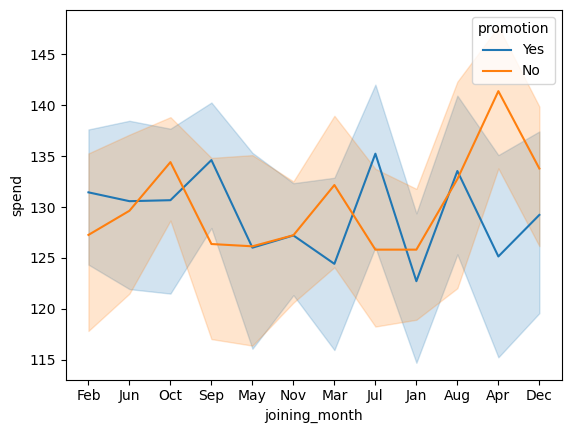

In [204]:
sns.lineplot(x="joining_month", y="spend", data=customer_train, hue="promotion")

No difference, I can remove this feature safely.

In [205]:
#remove what don't matter
customer_train = customer_train.drop(["customer_id", "promotion"], axis=1)
customer_test = customer_test.drop(["customer_id", "promotion"], axis=1)

In [206]:
#dummies
dummies_customer_train = pd.get_dummies(customer_train, drop_first=True)
dummies_customer_test = pd.get_dummies(customer_test, drop_first=True)
print(dummies_customer_train.info())
print(dummies_customer_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spend                      996 non-null    float64
 1   first_month                996 non-null    float64
 2   items_in_first_month       996 non-null    int64  
 3   region_Asia/Pacific        996 non-null    bool   
 4   region_Europe              996 non-null    bool   
 5   region_Middle East/Africa  996 non-null    bool   
 6   loyalty_years_1-3          996 non-null    bool   
 7   loyalty_years_10+          996 non-null    bool   
 8   loyalty_years_3-5          996 non-null    bool   
 9   loyalty_years_5-10         996 non-null    bool   
 10  joining_month_Aug          996 non-null    bool   
 11  joining_month_Dec          996 non-null    bool   
 12  joining_month_Feb          996 non-null    bool   
 13  joining_month_Jan          996 non-null    bool   

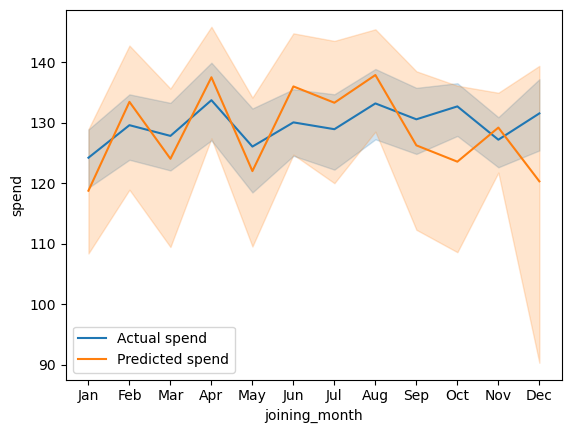

In [207]:
#Ridge
X_train = dummies_customer_train.drop("spend", axis=1).values
y_train = dummies_customer_train["spend"].values

X_test = dummies_customer_test.values

ridge.fit(X_train,y_train)
y_predict = ridge.predict(X_test)

customer_test["pred_spend"] = y_predict

ordered_calendar = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
customer_train["joining_month"] = customer_train["joining_month"].astype("category")
customer_train["joining_month"] = customer_train["joining_month"].cat.reorder_categories(ordered_calendar, ordered=True)
customer_test["joining_month"] = customer_test["joining_month"].astype("category")
customer_test["joining_month"] = customer_test["joining_month"].cat.reorder_categories(ordered_calendar, ordered=True)
sns.lineplot(x="joining_month", y="spend", data=customer_train, label="Actual spend")
sns.lineplot(x="joining_month", y="pred_spend", data=customer_test, label="Predicted spend")
plt.legend(loc="lower left")
plt.show()